2. Hafta – Veri Hazırlama + Önişleme

Toplam Veri Sayısı: 15000
Temizlik Sonrası Veri Sayısı: 11448
------------------------------
Sınıf Dağılımı:
Duygu_Sinifi
2    5838
0    2991
1    2619
Name: count, dtype: int64


/tmp/ipython-input-2210421642.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Duygu_Sinifi', data=df, palette='viridis')


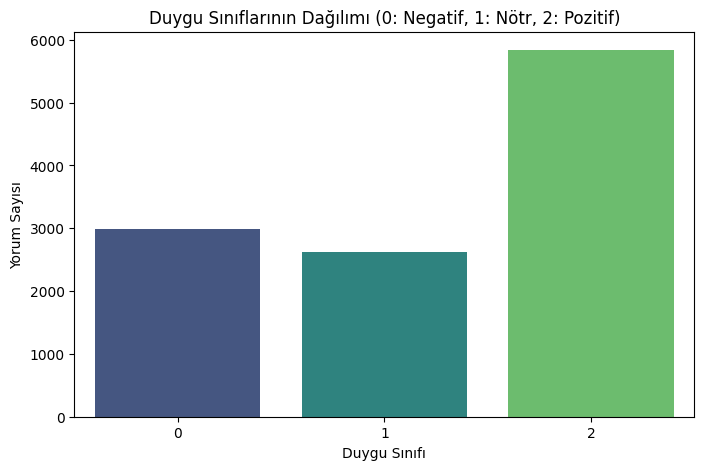

------------------------------
Eğitim Seti: 9158 satır
Doğrulama Seti: 1145 satır
Test Seti: 1145 satır
✅ Dosyalar başarıyla oluşturuldu: train.csv, validation.csv, test.csv


In [6]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import string
from sklearn.model_selection import train_test_split

# 1. VERİYİ YÜKLE
df = pd.read_csv("nlp_proje_verisi.csv", encoding='utf-8')
print(f"Toplam Veri Sayısı: {len(df)}")

# 2. VERİ TEMİZLEME ADIMLARI
# Yorum sütunu boş olan satırları siler
df = df.dropna(subset=['Yorum', 'Puan'])

# b. Tekrarlayan Veri Kontrolü (Duplicate temizliği)
# Aynı yorumdan birden fazla varsa siler (Sadece 1 tanesini tutar)
df = df.drop_duplicates(subset=['Yorum'])

print(f"Temizlik Sonrası Veri Sayısı: {len(df)}")

# 3. ETİKET DÖNÜŞÜMÜ (Label Mapping)
# Hedefimiz: 1-5 Puanı -> Negatif/Nötr/Pozitif'e çevirmek.
# 1-2 Puan -> Negatif (0)
# 3 Puan   -> Nötr (1)
# 4-5 Puan -> Pozitif (2)

def skor_donustur(puan):
    if puan <= 2:
        return 0 # Negatif
    elif puan == 3:
        return 1 # Nötr
    else:
        return 2 # Pozitif

df['Duygu_Sinifi'] = df['Puan'].apply(skor_donustur)

# 4. ÖN İŞLEME ADIMLARI (Preprocessing)
def metin_temizle(text):
    # a. Küçük harfe çevir (Lowercase)
    text = text.lower()

    # b. Gereksiz boşlukları sil
    text = text.strip()

    # c. Özel karakterleri ve noktalama işaretlerini temizle
    # Sadece Türkçe harfler ve boşluk kalsın
    text = text.translate(str.maketrans('', '', string.punctuation))

    # d. Fazla boşlukları teke indir
    text = re.sub(r'\s+', ' ', text)

    return text

# Temizlik fonksiyonunu uygula
df['Temiz_Yorum'] = df['Yorum'].apply(metin_temizle)

# 5. İSTATİSTİKLER VE GÖRSELLEŞTİRME
print("-" * 30)
print("Sınıf Dağılımı:")
print(df['Duygu_Sinifi'].value_counts())

# Grafik Çiz
plt.figure(figsize=(8,5))
sns.countplot(x='Duygu_Sinifi', data=df, palette='viridis')
plt.title('Duygu Sınıflarının Dağılımı (0: Negatif, 1: Nötr, 2: Pozitif)')
plt.xlabel('Duygu Sınıfı')
plt.ylabel('Yorum Sayısı')
plt.savefig('sinif_dagilimi.png') # Resmi kaydeder
plt.show()

# 6. EĞİTİM - TEST AYRIMI (Train-Test Split)
# Veriyi %80 Eğitim (Train), %10 Test (Test), %10 Doğrulama (Validation) olarak bölme.

X = df['Temiz_Yorum']
y = df['Duygu_Sinifi']

# Önce %80 Train, %20 Temp (Test+Val)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Sonra Temp'i ikiye böl (%10 Test, %10 Val)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("-" * 30)
print(f"Eğitim Seti: {len(X_train)} satır")
print(f"Doğrulama Seti: {len(X_val)} satır")
print(f"Test Seti: {len(X_test)} satır")

# 7. KAYDETME
# DataFrame'e çevirip kaydedelim
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
val_df = pd.DataFrame({'text': X_val, 'label': y_val})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

train_df.to_csv("train.csv", index=False, encoding='utf-8-sig')
val_df.to_csv("validation.csv", index=False, encoding='utf-8-sig')
test_df.to_csv("test.csv", index=False, encoding='utf-8-sig')

print("✅ Dosyalar başarıyla oluşturuldu: train.csv, validation.csv, test.csv")

3. Hafta – Modelleme

In [7]:
# 1. Kurulumlar ve Kütüphaneler
!pip install transformers datasets evaluate scikit-learn seaborn matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, DatasetDict

# GPU Kontrolü
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Kullanılan Cihaz: {device} (Eğer 'cpu' yazıyorsa eğitim çok yavaş olur!)")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00
Kullanılan Cihaz: cuda (Eğer 'cpu' yazıyorsa eğitim çok yavaş olur!)


In [8]:
# 2. VERİ YÜKLEME
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("validation.csv")
test_df = pd.read_csv("test.csv")

print(f"Eğitim Verisi: {len(train_df)}")
print(f"Test Verisi: {len(test_df)}")

Eğitim Verisi: 9158
Test Verisi: 1145


In [9]:
# 3. BASELINE MODEL (Referans Modeli: TF-IDF + Logistic Regression)
print("\n--- 1. MODEL: GELENEKSEL YÖNTEM (TF-IDF + LR) ---")

# Kelimeleri sayıya çevir (Embedding: TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train_df['text'].astype(str))
X_test_tfidf = vectorizer.transform(test_df['text'].astype(str))

# Modeli eğit
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, train_df['label'])

# Tahmin yap
lr_preds = lr_model.predict(X_test_tfidf)
lr_acc = accuracy_score(test_df['label'], lr_preds)

print(f"Geleneksel Model Başarısı (Accuracy): %{lr_acc*100:.2f}")
print("Sınıflandırma Raporu:\n", classification_report(test_df['label'],
                                                       lr_preds))


--- 1. MODEL: GELENEKSEL YÖNTEM (TF-IDF + LR) ---
Geleneksel Model Başarısı (Accuracy): %92.49
Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       299
           1       0.94      0.84      0.88       262
           2       0.91      0.97      0.94       584

    accuracy                           0.92      1145
   macro avg       0.93      0.91      0.92      1145
weighted avg       0.93      0.92      0.92      1145



In [10]:
# 4. ANA MODEL: BERT (Deep Learning)
print("\n--- 2. MODEL: MODERN YÖNTEM (BERTurk) ---")

model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Veriyi HuggingFace formatına çevir
dataset = DatasetDict({
    "train": load_dataset("csv", data_files="train.csv")['train'],
    "validation": load_dataset("csv", data_files="validation.csv")['train'],
    "test": load_dataset("csv", data_files="test.csv")['train']
})
# Tokenize Fonksiyonu
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length",
                     max_length=128)

tokenized_datasets = dataset.map(preprocess_function, batched=True)

# Modeli Yükle (3 Sınıf: 0, 1, 2)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=3)
model.to(device)

# Eğitim Ayarları (Hyperparameters)
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Her epoch sonunda test et
    save_strategy="epoch",
    learning_rate=2e-5,          # Çok küçük adımlarla öğren
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,          # Veri setini 3 kere dön
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir='./logs',
)

# Metrik Fonksiyonu
import evaluate
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Trainer Başlat
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)
# Eğitimi Başlat
print("BERT Eğitimi Başlıyor...")
trainer.train()


--- 2. MODEL: MODERN YÖNTEM (BERTurk) ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/9158 [00:00<?, ? examples/s]

Map:   0%|          | 0/1145 [00:00<?, ? examples/s]

Map:   0%|          | 0/1145 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT Eğitimi Başlıyor...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy
1,0.345100,0.108257,0.972926
2,0.102200,0.092819,0.980786
3,0.049100,0.082067,0.985153


TrainOutput(global_step=1719, training_loss=0.14845248833168656, metrics={'train_runtime': 1048.3126, 'train_samples_per_second': 26.208, 'train_steps_per_second': 1.64, 'total_flos': 1807194509664768.0, 'train_loss': 0.14845248833168656, 'epoch': 3.0})

In [11]:
# 5. SONUÇLAR
# Test seti üzerinde tahmin al
predictions = trainer.predict(tokenized_datasets["test"])
bert_preds = np.argmax(predictions.predictions, axis=-1)
bert_acc = accuracy_score(test_df['label'], bert_preds)

print(f"\nBERT Model Başarısı: %{bert_acc*100:.2f}")


BERT Model Başarısı: %97.90


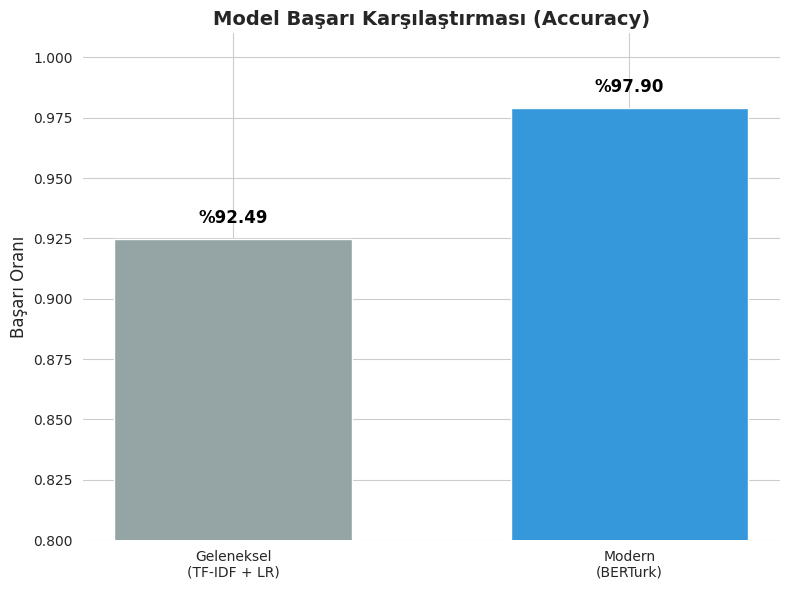

In [13]:
# Karşılaştırma Grafiği

import matplotlib.pyplot as plt
import seaborn as sns

# Grafik Stili (Daha temiz bir görünüm için)
sns.set_style("whitegrid")

# Veriler (Hafızadaki değişkenler için kullanılır)
methods = ['Geleneksel\n(TF-IDF + LR)', 'Modern\n(BERTurk)']
scores = [lr_acc, bert_acc]

# Renk Paleti (Soft Gri ve Kurumsal Mavi)
colors = ['#95a5a6', '#3498db']

plt.figure(figsize=(8, 6))
bars = plt.bar(methods, scores, color=colors, width=0.6)

# Ekseni Daraltma
plt.ylim(0.80, 1.01)

plt.title('Model Başarı Karşılaştırması (Accuracy)', fontsize=14, fontweight='bold')
plt.ylabel('Başarı Oranı', fontsize=12)

# Sütunların üzerine sayıları yazma
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'%{height*100:.2f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Kenar çizgilerini kaldırma
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.savefig("karsilastirma_grafigi.png", dpi=300)
plt.show()

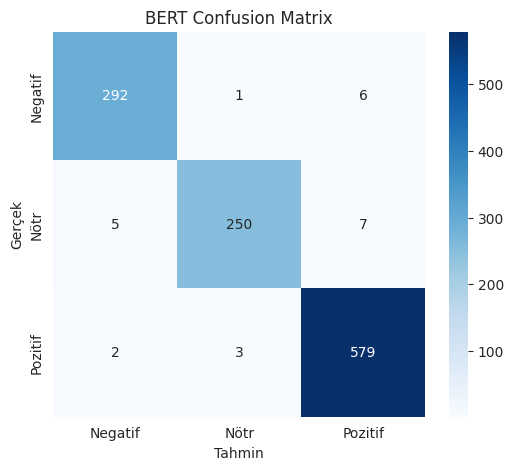

In [14]:
# BERT Confusion Matrix
cm = confusion_matrix(test_df['label'], bert_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif','Nötr','Pozitif'], yticklabels=['Negatif','Nötr','Pozitif'])
plt.title('BERT Confusion Matrix')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.savefig("bert_confusion_matrix.png")
plt.show()

In [17]:
# 6. Modeli Kaydet
model.save_pretrained("my_sentiment_model")
tokenizer.save_pretrained("my_sentiment_model")
print("Model 'my_sentiment_model' klasörüne kaydedildi.")

Model 'my_sentiment_model' klasörüne kaydedildi.


In [18]:
!zip -r model.zip my_sentiment_model

  adding: my_sentiment_model/ (stored 0%)
  adding: my_sentiment_model/tokenizer.json (deflated 70%)
  adding: my_sentiment_model/vocab.txt (deflated 53%)
  adding: my_sentiment_model/special_tokens_map.json (deflated 42%)
  adding: my_sentiment_model/model.safetensors (deflated 7%)
  adding: my_sentiment_model/tokenizer_config.json (deflated 75%)
  adding: my_sentiment_model/config.json (deflated 52%)


4. Hafta

In [20]:
from transformers import pipeline
import pandas as pd
import random

# 1. Modeli ve Test Verisini Yükle
print("⏳ Model yükleniyor...")
classifier = pipeline("sentiment-analysis", model="my_sentiment_model", tokenizer="my_sentiment_model")
df = pd.read_csv("test.csv")

# 2. Hataları Yakala
hatalar = []
print("🔍 Test verisi taranıyor...")

# Rastgele 200 tane seç
orneklem = df.sample(n=200, random_state=42)

for index, row in orneklem.iterrows():
    yorum = row['text']
    gercek = row['label'] # 0, 1, 2

    # Model tahmini
    try:
        sonuc = classifier(yorum[:512])[0]
        # Label dönüşümü (LABEL_0 -> 0, LABEL_1 -> 1, LABEL_2 -> 2)
        tahmin = int(sonuc['label'].split('_')[1])

        if gercek != tahmin:
            hatalar.append(f"Yorum: {yorum}\nGerçek: {gercek} | Tahmin: {tahmin}\n")
    except:
        continue

# 3. Sonuçları Göster
print("\n--- HATALI ÖRNEKLER (Rapora Yazılacaklar ---")
for hata in hatalar[:3]: # İlk 3 hatayı göster
    print(hata)
    print("-" * 30)

Device set to use cuda:0


⏳ Model yükleniyor...
🔍 Test verisi taranıyor...

--- HATALI ÖRNEKLER (Rapora Yazılacaklar ---
Yorum: yaklaşmayın benim hatam mı bilinmez aldıktan yaklaşık 4 gün sonra kulaklık bozuldu
Gerçek: 2 | Tahmin: 0

------------------------------
Yorum: çok şık ve sağlam ürünü 15 gün oldu alalı gerçekten kaliteli malzemeden ve oldukça sağlam görünüyor tabi büyük çocukları içine sokmazsanız 3 yaşına kadar idare eder ondan sonra da zaten yatakta yatar çocuğunuz ben piyasadan da araştırdım yaklaşık 35 oranında daha uygun teşekkürler hepsiburada
Gerçek: 1 | Tahmin: 2

------------------------------
Yorum: gayet güzel tulpar t5 model bilgisayarıma taktım montaj oldukça kolay ürün oldukça sessiz çalışıyor ortalama 120mb sn kopyalama hızı var ssd nin yanına gayet yeterli bir ürün kargo da oldukça hızlıydı pazar günü saat 01 30 da sipariş verdim ve uyudum saat 13 40 civarı elime ulaştı ürün 10 numara hızlı tavsiye ederim
Gerçek: 1 | Tahmin: 2

------------------------------
